In [7]:
import pandas_profiling
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt
import statsmodels.api as sm # import statsmodels 
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
#https://scikit-learn.org/stable/modules/model_evaluation.html
#todo: add adjusted r2
from sklearn.metrics import explained_variance_score,mean_absolute_error,mean_squared_error,mean_squared_log_error,r2_score
import catboost as cb
from sklearn.preprocessing import StandardScaler
import pickle


In [8]:
def evalRegressor(model, x_test, y_test):
    y_pred = model.predict(x_test)
    evs = explained_variance_score(y_test,y_pred)
    mae = mean_absolute_error(y_test,y_pred)
    mse = mean_squared_error(y_test,y_pred)
    #msl = mean_squared_log_error(y_test,y_pred)
    msl = 0
    r2 = r2_score(y_test,y_pred)
    Ar2 = 1-(1-r2)*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)
    return y_pred,evs,mae,mse,msl,r2,Ar2

In [9]:
df=pd.read_csv('cleanData.csv')

In [25]:
dfNoNA = df.fillna(df.mean())

In [26]:
fea = np.concatenate((['host_listings_count','bedrooms','accommodates','daysToLastReview',
                       'calculated_host_listings_count_entire_homes','guests_included',
                       'zipcode','bathrooms','number_of_reviews_ltm','calendar_updated2',
                       'cleaning_fee','extra_people','harvesine_distance','host_id',
                       'host_response_rate','calculated_host_listings_count',
                       'Elevator','beds','daysToHostSince','security_deposit',
                       'Hangers','Paid parking on premises','review_scores_rating',
                       'Shampoo','Hot water','Income_per_month', 'Coffee maker',
                       'Dishwasher'],df.loc[:,df.columns.str.contains('room_type_')].columns.values,
                       df.loc[:,df.columns.str.contains('neighbourhood_group_cleansed_')].columns.values,
                       df.loc[:,df.columns.str.contains('host_response_time_')].columns.values,
                       df.loc[:,df.columns.str.contains('host_location_')].columns.values,
                       df.loc[:,df.columns.str.contains('property_type_')].columns.values,
                       df.loc[:,df.columns.str.contains('cancellation_policy_strict')].columns.values))


In [27]:
o_dfNoNA = dfNoNA.copy()
dfNoNA = dfNoNA.filter(items=fea)

In [28]:
dfNoNA.isna().sum() 

host_listings_count                                0
bedrooms                                           0
accommodates                                       0
daysToLastReview                                   0
calculated_host_listings_count_entire_homes        0
guests_included                                    0
zipcode                                            0
bathrooms                                          0
number_of_reviews_ltm                              0
calendar_updated2                                  0
cleaning_fee                                       0
extra_people                                       0
harvesine_distance                                 0
host_id                                            0
host_response_rate                                 0
calculated_host_listings_count                     0
Elevator                                           0
beds                                               0
daysToHostSince                               

In [29]:
XNoNA = dfNoNA.drop(['Income_per_month'], axis=1)
yNoNA = dfNoNA['Income_per_month']

In [127]:
X_trainNoNA, X_testNoNA, y_trainNoNA, y_testNoNA = train_test_split(XNoNA, yNoNA)


In [113]:
X = df.drop(['Income_per_month'], axis=1)
y = df['Income_per_month']

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y)


In [128]:
dfNoNA.shape

(16213, 78)

In [129]:
params = {
            'max_depth': [3, 4, 5, None,10],
            'n_estimators': [10, 100, 200, 400,600,1000],
            'max_features': [2,4,6,10,15,30,50],
            'min_samples_leaf': [1,3,5,10,50,30]
            #'learning_rate':[0.000001,0.0001,0.01,0.1]
        }

estimator=RandomForestRegressor()
Final_CLF_RF = GridSearchCV(estimator=estimator, param_grid=params, cv=5, n_jobs=-1)
Final_CLF_RF.fit(X_trainNoNA, np.ravel(y_trainNoNA))

KeyboardInterrupt: 

In [67]:
# save the model to disk
filenameRF = 'Final_RF_LF.pkl'
pickle.dump(Final_CLF_RF, open(filenameRF, 'wb'))

In [68]:
RF_FI = pd.Series(Final_CLF_RF.best_estimator_.feature_importances_, index = X_testNoNA.columns).sort_values(ascending=False)
RF_FI.to_csv('FeatureImportance_rf.csv')

C:\Users\Elham\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [69]:
y_pred_RF,evs_RF,mae_RF,mse_RF,msl_RF,r2_RF,Ar2_RF = evalRegressor(Final_CLF_RF,X_testNoNA, y_testNoNA)


In [70]:
y_pred_RF,evs_RF,mae_RF,mse_RF,msl_RF,r2_RF,Ar2_RF

(array([2843.37369274, 1382.71978644, 2651.42779984, ..., 2237.83126882,
        2196.15722278, 2020.28062496]),
 0.6040701117445945,
 1010.1405570255685,
 3006859.2593017863,
 0,
 0.6039180185890876,
 0.596044219763858)

In [71]:
Final_CLF_RF.cv_results_

{'mean_fit_time': array([7.45564461e-02, 3.88976669e-01, 6.40833569e-01, ...,
        3.26853416e+01, 4.91230503e+01, 7.69411127e+01]),
 'std_fit_time': array([3.13531245e-03, 1.91242407e-02, 5.08569377e-02, ...,
        1.57038573e-01, 1.76661222e-01, 7.14815547e+00]),
 'mean_score_time': array([0.00919566, 0.03578038, 0.03817892, ..., 0.13732171, 0.21207891,
        0.33041229]),
 'std_score_time': array([0.00116551, 0.01041346, 0.0030578 , ..., 0.01627095, 0.02386434,
        0.030047  ]),
 'param_max_depth': masked_array(data=[3, 3, 3, ..., 10, 10, 10],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=[2, 2, 2, ..., 50, 50, 50],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[1, 1, 1, ..., 30, 30, 30],
              mask=[False, False, False, ..., False, F

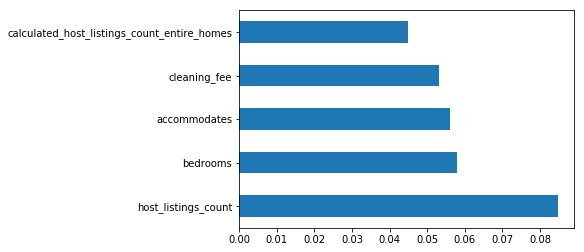

In [72]:
feat_importances_RF = pd.Series(Final_CLF_RF.best_estimator_.feature_importances_, index=X_trainNoNA.columns)
feat_importances_RF.nlargest(5).plot(kind='barh')

In [73]:
Final_CLF_RF.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=10, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [ ]:
params = {'depth':[3,1,6,10],
          'iterations':[100,300],
          'learning_rate':[0.0001,0.001,0.01,0.1,0.3], 
          'l2_leaf_reg':[3,1,5,10,40],
          'border_count':[32,5,20,50,100],
          #'ctr_border_count':[50,5,10,20,100,200],
          'thread_count':[4]}
estimator=cb.CatBoostRegressor()
#estimator=cb.CatBoostRegressor(cat_features=X_trainNoNA.select_dtypes(exclude=[np.number]).columns )
Final_CLF_CAT = GridSearchCV(estimator=estimator, param_grid=params, cv=5, n_jobs=-1)
Final_CLF_CAT.fit(X_trainNoNA, y_trainNoNA)

In [ ]:
y_pred_CAT,evs_CAT,mae_CAT,mse_CAT,msl_CAT,r2_CAT,Ar2_CAT = evalRegressor(Final_CLF_CAT,X_testNoNA, y_testNoNA)


In [ ]:
y_pred_CAT,evs_CAT,mae_CAT,mse_CAT,msl_CAT,r2_CAT,Ar2_CAT

In [ ]:
filenameCat3 = 'Final_Cat3.pkl'
pickle.dump(Final_CLF_CAT, open(filenameCat3, 'wb'))

In [ ]:
Final_CLF_CAT.best_estimator_

In [ ]:
CAT_FI = pd.Series(Final_CLF_CAT.best_estimator_.feature_importances_, index = X_testNoNA.columns).sort_values(ascending=False)
CAT_FI.to_csv('FeatureImportance_cat3.csv')

In [10]:
                       df.loc[:,df.loc[:,[df.columns.str.contains('room_type_')].columns.values,
                       df.loc[:,df.columns.str.contains('neighbourhood_group_cleansed_')].columns.values,
                       df.loc[:,df.columns.str.contains('host_response_time_')].columns.values,
                       df.loc[:,df.columns.str.contains('host_location_')].columns.values,
                       df.loc[:,df.columns.str.contains('property_type_')].columns.values,
                       df.loc[:,df.columns.str.contains('cancellation_policy_strict')].columns.values]].columns

AttributeError: 'list' object has no attribute 'columns'

In [20]:
df.loc[:,df.columns.str.contains('cancellation_policy')].columns.values

array(['cancellation_policy_flexible', 'cancellation_policy_moderate',
       'cancellation_policy_strict',
       'cancellation_policy_strict_14_with_grace_period',
       'cancellation_policy_super_strict_30',
       'cancellation_policy_super_strict_60'], dtype=object)

In [21]:
df['daysToFirstreview'].describe()

count    13483.000000
mean       518.258844
std        497.964851
min        -15.000000
25%        135.000000
50%        341.000000
75%        830.000000
max       3754.000000
Name: daysToFirstreview, dtype: float64

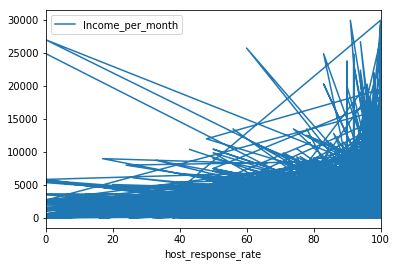

In [35]:
df.plot(x='host_response_rate', y='Income_per_month')

In [30]:
dfNoNA.head().to_csv('headLF.csv')

In [34]:
dfNoNA['harvesine_distance'].mean()

12356.994204980996

In [36]:
dfNoNA.columns

Index(['host_listings_count', 'bedrooms', 'accommodates', 'daysToLastReview',
       'calculated_host_listings_count_entire_homes', 'guests_included',
       'zipcode', 'bathrooms', 'number_of_reviews_ltm', 'calendar_updated2',
       'cleaning_fee', 'extra_people', 'harvesine_distance', 'host_id',
       'host_response_rate', 'calculated_host_listings_count', 'Elevator',
       'beds', 'daysToHostSince', 'security_deposit', 'Hangers',
       'Paid parking on premises', 'review_scores_rating', 'Shampoo',
       'Hot water', 'Income_per_month', 'Coffee maker', 'Dishwasher',
       'room_type_Entire home/apt', 'room_type_Private room',
       'room_type_Shared room', 'neighbourhood_group_cleansed_Ballard',
       'neighbourhood_group_cleansed_Beacon Hill',
       'neighbourhood_group_cleansed_Capitol Hill',
       'neighbourhood_group_cleansed_Cascade',
       'neighbourhood_group_cleansed_Central Area',
       'neighbourhood_group_cleansed_Delridge',
       'neighbourhood_group_cleansed